In [46]:
import tensorflow as tf
from PIL import Image
import os
from urllib.request import urlopen
import io
import seaborn as sns
import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from skimage.filters import window
from multipledispatch import dispatch
import itertools
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Helper libraries
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sn
from copy import deepcopy
from pathlib import Path

#from urllib.error import HTTPError
import sys

# for augmentation part 
#import albumentations as A

# for classification_report overriding
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import precision_recall_fscore_support
from tabulate import tabulate

#TO DO

1. УЗНАТЬ С КАКОГО ПОРОГА ИЗОБРАЖЕНИЕ ЗАБЛЮРЕНО И ОПРЕДЕЛИТЬ ПОРОГИ ОБЕИХ БАЗ
2. (ДЛЯ 1) ПОСТРОИТЬ ГРАФИКИ ТОЧЕК ЗАБЛЮРЕННОСТИ
3. (ДЛЯ 2) ПОДУМАТЬ О ГРАФИКЕ
4. АУГМЕНТИРОВАТЬ МАССИВЫ (НЕ ДУМАЮ ЧТО ОН ВООБЩЕ МОЖЕТ ПЕРЕОБУЧИТЬСЯ НА НИХ, ЕСЛИ СОБИРАЛИСЬ ОНИ ОДНИМ ОБРАЗОМ) БОЛЬШЕ НАВЕРНО ПРОСТО ПЕРЕВОРАЧИВАТЬ ИХ МОЖНО И ЗЕРКАЛИТЬ, БЛЮРЕТЬ НЕ РЕШУСЬ, ЦВЕТА НИЧЕГО НЕ МЕНЯЮТ, ВСЁ В СЕРЫХ ТОНАХ ОБРАБАТЫВАЕТСЯ
5. ЛУЧШЕ ПОДОБРАТЬ ПАРАМЕТРЫ СЛОЁВ

(640, 640, 3)


(-0.5, 639.5, 639.5, -0.5)

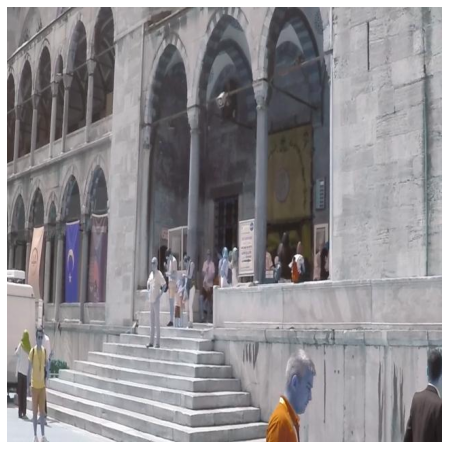

In [2]:
# img = cv2.imread("/kaggle/input/shift-cv-winter-2023/train/train/kagouracdzwrjjxzzedi.jpg")
# img_size = img.shape
# print(img_size)
# plt.figure(figsize=(8,8))
# plt.imshow(img)
# plt.axis('off')

In [3]:
def classification_report(y_true, y_pred, labels=None, 
                          target_names=['Not Pumpyy pooo', 'Pumpy pooo'],
                          sample_weight=None, digits=4, tablfmt='pipe'):
    
    floatfmt = '.{:}f'.format(digits)
    if labels is None:
        labels = unique_labels(y_true, y_pred)
    else:
        labels = np.asarray(labels)

    if target_names is not None and len(labels) != len(target_names):
        print(
            "labels size, {0}, does not match size of target_names, {1}"
            .format(len(labels), len(target_names))
        )

    last_line_heading = 'avg / total'

    if target_names is None:
        target_names = [u'%s' % l for l in labels]

    headers = ["precision", "recall", "f1-score", "support"]

    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred,
                                                  labels=labels,
                                                  average=None,
                                                  sample_weight=sample_weight)

    rows = zip(target_names, p, r, f1, s)
    tbl_rows = []
    for row in rows:
        tbl_rows.append(row)

    # compute averages
    last_row = (last_line_heading,
                np.average(p, weights=s),
                np.average(r, weights=s),
                np.average(f1, weights=s),
                np.sum(s))
    tbl_rows.append(last_row)
    return tabulate(tbl_rows, headers=headers,
                    tablefmt=tablfmt, floatfmt=floatfmt)

In [5]:
# TO SHOW IMAGE

# def magick(steeevaaa):


#     plt.figure(figsize=(8,8))
#     plt.imshow(steeevaaa)
#     plt.axis('off')

In [4]:
marker_set = pd.read_csv("/kaggle/input/shift-cv-winter-2023/train.csv", sep=',', header=None)[1:]
#rint(marker_set[1])

In [7]:
x_full = []
y_full = []

x_train = []
y_train = []

x_test = []
y_test = []

In [14]:
# x_test = []
# y_test = []

In [ ]:
# img_0 = cv2.imread('/content/0.jpg',0)
# img_1 = cv2.imread('/content/aefilcxppgkwhnusvziq.jpg',0)
# size = 32

# img_0 = img_0 * window('hann', img_0.shape)
# img_1 = img_1 * window('hann', img_1.shape)

# plt.subplot(121),plt.imshow(img_0, cmap = 'gray')
# plt.title('No blure Hann'), plt.xticks([]), plt.yticks([])

# plt.subplot(122),plt.imshow(img_1, cmap = 'gray')
# plt.title('Blure Hann'), plt.xticks([]), plt.yticks([])
# plt.show()

# f_0 = np.fft.fft2(img_0)
# fshift_0 = np.fft.fftshift(f_0)
# magnitude_spectrum_0 = 20*np.log(np.abs(fshift_0))
# magnitude_spectrum_0 = cv2.resize(magnitude_spectrum_0, dsize=(size, size))

# f_1 = np.fft.fft2(img_1)
# fshift_1 = np.fft.fftshift(f_1)
# magnitude_spectrum_1 = 20*np.log(np.abs(fshift_1))
# magnitude_spectrum_1 = cv2.resize(magnitude_spectrum_1, dsize=(size, size))

# plt.subplot(121),plt.imshow(magnitude_spectrum_0, cmap = 'gray')
# plt.title('No blure'), plt.xticks([]), plt.yticks([])

# plt.subplot(122),plt.imshow(magnitude_spectrum_1, cmap = 'gray')
# plt.title('Blure'), plt.xticks([]), plt.yticks([])
# plt.show()

In [8]:
size = 32

In [9]:
def hann_and_fft(img):
    size = 32

    img = img * window('hann', img.shape)

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    magnitude_spectrum = cv2.resize(magnitude_spectrum, dsize=(size, size))

    return(magnitude_spectrum)

In [10]:
# TO MAKE ARRAY OF TRAINING SET

#df_train = pd.read_csv('/kaggle/input/shift-cv-winter-2023/train.csv')
path_train = '/kaggle/input/shift-cv-winter-2023/train/train/'

temp_p = ''
temp_n = 0
size = 32
i = 0

for elem in range(len(marker_set[0])):
    temp_p = path_train + marker_set[0][elem + 1]
    #temp_a = cv2.imread(temp_p)
    #temp_n = int(float(marker_set[1][elem + 1]))
    #train_set.append([temp_a, int(float(temp_n))])
    temp_a = cv2.imread(temp_p, 0)
    temp_a = hann_and_fft(temp_a)
    #temp_a = cv2.cvtColor(cv2.resize(temp_a, dsize=(size, size)), cv2.COLOR_BGR2RGB)
    temp_n = int(float(marker_set[1][elem + 1]))
    i += 1
    
#     x_full.append(temp_a)
#     y_full.append(temp_n)
    
    x_train.append(temp_a)
    y_train.append(temp_n)

print(f'i: {i}')
print(f'len(x_train): {len(x_train)}')

i: 2664
len(x_train): 0


In [12]:
# TO MAKE ARRAY OF TEST SET

path_test = '/kaggle/input/shift-cv-winter-2023/test/test/'
path = Path(path_test)
test_count = len(list(path.iterdir()))

temp_a = []
temp_p = ''
size = 32

os.chdir(path_test)

for elem in os.listdir(path_test):
    #print(str(img))
    temp_a =  cv2.imread(elem, 0)
    temp_a = hann_and_fft(temp_a)
    # color channel conversion and circumcision))
    #temp_a = cv2.cvtColor(cv2.resize(temp_a, dsize=(size, size)), cv2.COLOR_BGR2RGB)

    x_test.append(temp_a)

In [13]:
print(len(x_test))

1341


In [63]:
# BUILDING A RIGHT ARRAY MODE
# NO SPLITING ON TEST

x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape(-1, size, size, 1)
x_train = x_train/255

x_test = x_test.reshape(-1, size, size, 1)
x_test = x_test/255

print(f'x_train shape is : {x_train.shape}')  # debag
print(f'x_test shape is : {x_test.shape}')  # debag

y_train = to_categorical(y_train, num_classes=2)
print(f'y_train shape is : {y_train.shape}')  # debag

#y_test = to_categorical(y_test, num_classes = 2)

x_train shape is : (2664, 32, 32, 1)
x_test shape is : (774, 32, 32, 1)
y_train shape is : (2664, 2)


None


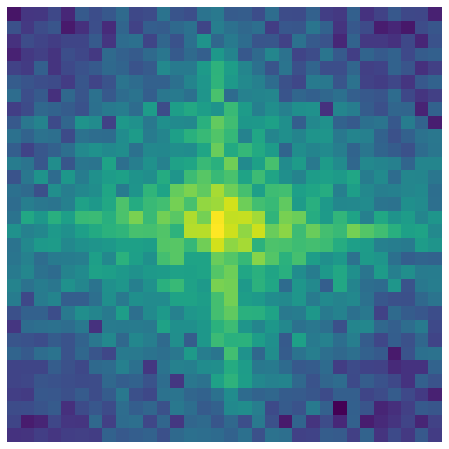

In [30]:
# print(magick(x_train[0]))

In [31]:
size = 32

In [15]:
# BUILDING A RIGHT ARRAY MODE

# x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.2, random_state=42, shuffle=True)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=True)
# print(f'x_train shape is : {len(x_train)}')
# x_train = np.array(x_train)
# x_test = np.array(x_test)

# x_train = x_train.reshape(-1, size, size, 1)
# x_train = x_train/255

# x_test = x_test.reshape(-1, size, size, 1)
# x_test = x_test/255

# print(f'x_train shape is : {x_train.shape}')  # debag
# print(f'x_test shape is : {x_test.shape}')  # debag

# y_train = to_categorical(y_train, num_classes=2)
# print(f'y_train shape is : {y_train.shape}')  # debag

# y_test = to_categorical(y_test, num_classes = 2)

x_train shape is : 1704
x_train shape is : (1704, 32, 32, 1)
x_test shape is : (533, 32, 32, 1)
y_train shape is : (1704, 2)


In [ ]:
print(y_full)

In [16]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(size, size,1)))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(size, size,1)))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(size, size,1)))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

optimizer=Adam(learning_rate=0.001)

model.summary()

2023-01-05 10:36:54.067473: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 512)         5

In [17]:

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], )
epochs = 120
batch_size = 32
datagen = ImageDataGenerator(featurewise_center=False, 
                             samplewise_center=False, 
                             featurewise_std_normalization=False, 
                             samplewise_std_normalization=False, 
                             zca_whitening=False, 
                             zca_epsilon=0.000001, 
                             rotation_range=0.5, 
                             width_shift_range=0, 
                             height_shift_range=0, 
                             brightness_range=None, 
                             shear_range=0, 
                             zoom_range=0.5, 
                             channel_shift_range=0, 
                             fill_mode='nearest', 
                             cval=0, 
                             horizontal_flip=False, 
                             vertical_flip=False)

datagen.fit(x_train)
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs, steps_per_epoch=x_train.shape[0]//batch_size)

2023-01-05 10:38:15.021351: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/120
53/53 [==============================] - 8s 130ms/step - loss: 1.2509 - accuracy: 0.7811
Epoch 2/120
53/53 [==============================] - 7s 129ms/step - loss: 0.6381 - accuracy: 0.8176
Epoch 3/120
53/53 [==============================] - 8s 141ms/step - loss: 0.5864 - accuracy: 0.8206
Epoch 4/120
53/53 [==============================] - 7s 125ms/step - loss: 0.3841 - accuracy: 0.8636
Epoch 5/120
53/53 [==============================] - 7s 127ms/step - loss: 0.4090 - accuracy: 0.8696
Epoch 6/120
53/53 [==============================] - 7s 140ms/step - loss: 0.4184 - accuracy: 0.8630
Epoch 7/120
53/53 [==============================] - 7s 124ms/step - loss: 0.3543 - accuracy: 0.8684
Epoch 8/120
53/53 [==============================] - 7s 123ms/step - loss: 0.3585 - accuracy: 0.8768
Epoch 9/120
53/53 [==============================] - 7s 124ms/step - loss: 0.4170 - accuracy: 0.8786
Epoch 10/120
53/53 [==============================] - 7s 124ms/step - loss: 0.4525 - accura

In [18]:
y_pred = model.predict(x_test)

In [19]:
# print(y_pred)

[[9.7489923e-01 2.5100825e-02]
 [4.2282135e-16 1.0000000e+00]
 [9.1286248e-01 8.7137602e-02]
 ...
 [3.3133557e-01 6.6866446e-01]
 [2.3671673e-04 9.9976331e-01]
 [2.8028525e-04 9.9971968e-01]]


In [41]:
# pred_points = y_pred

# # iter = lambda item, l = len(pred_points): print(item[l])
# # iter(pred_points)
# # pred_points = list(filter(lambda arr : round(arr, 4), pred_points))
# # print(pred_points)
# for i in range(len(pred_points)):
#     for j in range(2):
#         pred_points[i][j] = round(pred_points[i][j], 3)
# #         print(pred_points[i][j])

# print(pred_points)

[[0.975 0.025]
 [0.    1.   ]
 [0.913 0.087]
 ...
 [0.331 0.669]
 [0.    1.   ]
 [0.    1.   ]]


In [54]:
print()

In [63]:
# for i in range(len(pred_points)):
#     print(pred_points[i][1])

0.025
1.0
0.087
0.926
0.007
1.0
1.0
1.0
1.0
1.0
0.817
0.937
1.0
0.136
1.0
1.0
0.213
0.02
0.286
1.0
0.988
0.999
0.036
0.39
0.865
0.528
1.0
0.32
0.974
1.0
0.194
0.552
1.0
0.036
0.001
0.952
1.0
1.0
0.268
0.876
0.004
0.999
0.927
1.0
1.0
0.019
1.0
0.998
1.0
0.502
0.016
0.921
1.0
0.129
1.0
0.008
0.298
1.0
1.0
1.0
0.0
0.507
0.617
0.335
1.0
1.0
0.0
0.045
0.025
0.062
1.0
0.5
1.0
0.365
0.818
0.109
0.546
0.337
1.0
0.149
0.017
0.066
0.004
1.0
0.946
1.0
0.0
0.0
0.409
1.0
0.769
1.0
1.0
0.362
1.0
0.497
0.659
1.0
0.074
0.393
0.341
1.0
0.978
0.011
0.405
0.003
0.005
0.068
0.339
1.0
0.999
0.86
0.998
0.056
1.0
0.99
1.0
0.154
0.036
0.1
0.639
0.999
0.989
0.008
0.124
0.995
0.0
0.125
0.993
0.999
0.77
1.0
0.013
0.907
0.894
1.0
1.0
1.0
1.0
1.0
1.0
0.006
0.877
0.678
1.0
0.001
1.0
0.871
1.0
1.0
0.979
1.0
0.171
0.055
1.0
0.002
0.996
0.999
0.633
0.035
0.565
0.999
0.985
0.94
0.549
0.087
1.0
1.0
1.0
1.0
1.0
0.956
0.867
0.907
0.979
0.965
0.011
1.0
1.0
1.0
0.66
1.0
0.0
1.0
0.216
0.065
0.024
0.001
1.0
1.0
0.739
1.0
0.98

In [72]:
# b_true = []
# b_false = []

# false = []



# for i in range(len(pred_points)):
# #     b_true.append(pred_points[i][1] if y_true[i] == 1 else pass)
#     if y_true[i] == 0:
#         b_true.append(pred_points[i][0])
        
#     else:
#         b_false.append(pred_points[i][0])
#         if pred_points[i][0] > 0.5:
#             false.append(pred_points[i][0])

        
# print(false)
# print('//////')   
# print(b_true) # вероятность тех, которые должны быть выбраны
# print('//////')
# print(b_false) # вероятность тех, которые НЕ должны быть выбраны

[0.964, 0.638, 0.913, 0.64]
//////
[0.975, 0.913, 0.993, 0.063, 0.864, 0.787, 0.98, 0.714, 0.964, 0.61, 0.135, 0.472, 0.68, 0.806, 0.448, 0.999, 0.048, 0.732, 0.124, 0.996, 0.073, 0.981, 0.498, 0.984, 0.871, 0.992, 0.702, 1.0, 0.493, 0.665, 1.0, 0.955, 0.975, 0.938, 0.5, 0.635, 0.182, 0.891, 0.454, 0.663, 0.851, 0.983, 0.934, 0.996, 0.054, 1.0, 1.0, 0.591, 0.503, 0.341, 0.926, 0.607, 0.659, 0.989, 0.595, 0.997, 0.995, 0.932, 0.661, 0.001, 0.14, 0.944, 0.846, 0.964, 0.9, 0.361, 0.992, 0.876, 1.0, 0.875, 0.007, 0.23, 0.987, 0.093, 0.106, 0.994, 0.123, 0.322, 0.999, 0.129, 0.829, 0.945, 0.998, 0.367, 0.965, 0.435, 0.06, 0.451, 0.133, 0.035, 0.989, 0.34, 1.0, 0.784, 0.935, 0.976, 0.999, 0.261, 0.995, 0.903, 0.937, 0.99, 0.313, 0.502, 0.384, 0.922, 1.0, 1.0, 0.992, 0.856, 0.002, 1.0, 0.992, 0.898, 0.906, 0.271, 0.09, 0.957, 0.122, 0.998, 0.039, 1.0, 0.281, 0.042, 0.587, 0.934, 1.0, 0.278, 1.0, 0.89, 1.0, 0.266, 0.706, 0.874, 0.012, 0.774, 0.099, 0.654, 0.154, 0.932, 1.0, 1.0, 0.011, 0.357, 

|                 |   precision |   recall |   f1-score |   support |
|:----------------|------------:|---------:|-----------:|----------:|
| Not Pumpyy pooo |      0.9801 |   0.6937 |     0.8124 |  284.0000 |
| Pumpy pooo      |      0.7380 |   0.9839 |     0.8434 |  249.0000 |
| avg / total     |      0.8670 |   0.8293 |     0.8269 |  533.0000 |


NameError: name 'classes' is not defined

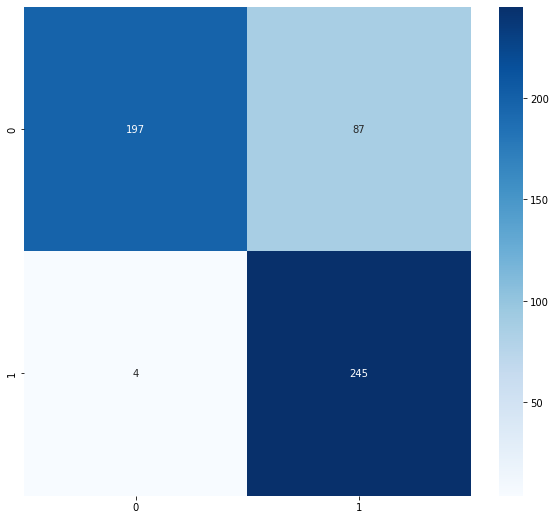

In [20]:

# y_pred_clst = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_test, axis=1)
# conf_matt = confusion_matrix(y_true, y_pred_clst)
# print(classification_report(y_true, y_pred_clst))
# f, ax = plt.subplots(figsize=(10, 9))
# sns.heatmap(conf_matt, annot=True, fmt='.0f', cmap='Blues')
# # ax.set_xticklabels([item + ' (true)' for item in classes])
# # ax.set_yticklabels([item + ' (pred)' for item in classes])
# plt.show()

In [21]:
# print(y_pred_clst)

[0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0 1 1
 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0
 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1
 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1
 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0
 0 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1
 1 1 0 1 1 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1
 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1
 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1
 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1
 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1
 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1
 0 0 1 0 0 1 1 1 1 0 1 1 

In [68]:
# y_pred_clst = np.argmax(y_pred, axis=1)
# print(y_pred_clst)

[0 1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0
 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0
 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1
 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1
 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 

In [52]:
# print(y_pred[1][0])

0.0012366


In [ ]:
subm = []
for i in range(len(y_pred)):
    if y_pred[i][1] > 0.9: subm.append('1')
    if y_pred[i][0] > y_pred[i][1]: 
        subm.append('0')
    else: subm.append('0')
# print(subm)

In [59]:
# subm = []
# for i in range(len(y_pred)):
#     if y_pred[i][0] > y_pred[i][1]: 
#         subm.append('0')
#     else: subm.append('1')
# # print(subm)

['0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0',

In [61]:
# im_pred = pd.DataFrame(subm)
# print(im_pred)

     0
0    0
1    1
2    0
3    1
4    0
..  ..
769  0
770  0
771  0
772  0
773  1

[774 rows x 1 columns]


In [56]:
files = os.listdir(path_test)
# im_name = pd.DataFrame(files)
# print(im_name)

                            0
0    sayzffvvevfqhcvbidcl.jpg
1    momggphlkddgzvoyoiub.jpg
2    axwqnvsyiuqhfygkwmmo.jpg
3    qnsjzywzoxvejgewkzdj.jpg
4    lnhouaiubslildofoiax.jpg
..                        ...
769  czuxsqomfyyggkhequyy.jpg
770  qxdhtkagyebqoahislzb.jpg
771  ciditffmiqnmbbxklcrw.jpg
772  hlxjtdswmckwvjpuqdfg.jpg
773  onotrkeirxodtyfksqrx.jpg

[774 rows x 1 columns]


In [65]:
os.chdir('/kaggle/working/')

In [66]:
output = pd.DataFrame({'filename': files, 'blur': subm})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [39]:
# for root, dirs, files in os.walk("."):  
#     for filename in files:
#         print(filename)

sayzffvvevfqhcvbidcl.jpg
momggphlkddgzvoyoiub.jpg
axwqnvsyiuqhfygkwmmo.jpg
qnsjzywzoxvejgewkzdj.jpg
lnhouaiubslildofoiax.jpg
dhgqbhtozuesxwyconpq.jpg
xbgkfqzykfmxqqsievng.jpg
meyhbflotbzqsykxiokb.jpg
eymxkinudunmlvnfhlyg.jpg
cdofnicgfwkkmhtlknqh.jpg
dufxhphtkcneaaxcoqlf.jpg
vaqkyulwhjpifjazqrio.jpg
odnjjnyvmrmkxyofmrtz.jpg
jzqaavxlboxaqzgbpklu.jpg
mtvuyfoqqktornupmnqi.jpg
zytbqidsjtourxzyfasw.jpg
uncyswkmadvcrtdgwiow.jpg
vyxsrcohplvrmudpnqmp.jpg
ohrwiupqwajxfpsoorkp.jpg
azqyrckboqvjbhpfpiws.jpg
joqajbejnjwujozynvqt.jpg
rpsebdqhvkmenufcndcy.jpg
yukosvxahjdwphyunwvw.jpg
jjezszamxjvuxdotoqqs.jpg
zmmilxfeicripvvkaoot.jpg
tymqqgxnfaewztpyursx.jpg
dnxfjtkxdwutrsixnasw.jpg
xjzibwpysqxflunnzfoi.jpg
dscjlkfreeefhfhxnvot.jpg
whbvjjzmmghmeckbokhd.jpg
dpruqgpcwdjjqnfxmizt.jpg
hsotgdhdhnqtczyommpo.jpg
gsuavyiywupanhubikcd.jpg
curxlqokritvivupbvae.jpg
vfyudylrqrfekkleucpp.jpg
wpjhqkpoueiogrwwbhnq.jpg
tdkyminsnnhvwtlrklvt.jpg
uibemuqrejkispjiiqmr.jpg
fkoujrdmhuitiylzoudg.jpg
vgfgnaoefsnubvojrkht.jpg


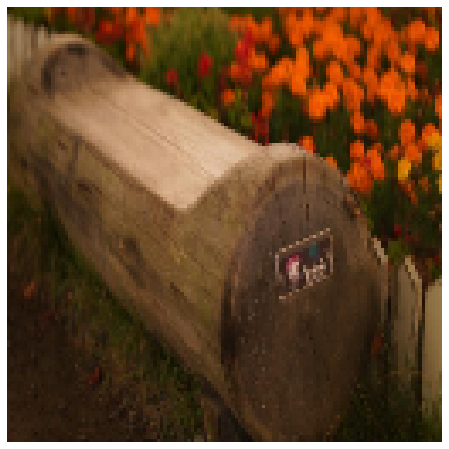

In [44]:
# magick(x_test[-1])

In [ ]:
# plt.plot(history.history['accuracy'], label='acc', color='orange')
# plt.plot(history.history['loss'], label='loss', color='blue')
# plt.legend()